# Installing Dependencies

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.15.0
!pip install keras==1.2.2
!pip install h5py==2.10.0

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.5 MB 8.0 kB/s 
     |████████████████████████████████| 3.8 MB 54.6 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 503 kB 57.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=be7462d8b5d8ed1e3180320898c77536e1dfd3a887d3353d535b5daf02f4a810
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.

#Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/UNet_tf

/content/drive/MyDrive/isbi-2012-master


## Importing Libraries

In [ ]:
import numpy as np
import os
import pickle
import tifffile as tiff
from time import time
from os import path, mkdir
from skimage import io, transform
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape, Lambda, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#import argparse
import keras.backend as K
import logging

from src.utils.runtime import funcname, gpu_selection
from src.utils.model import dice_coef, dice_coef_loss, KerasHistoryPlotCallback, KerasSimpleLoggerCallback, \
    jaccard_coef, jaccard_coef_int
from src.utils.data import random_transforms

Using TensorFlow backend.


## Defining Variables

In [ ]:
model_path='checkpoints'
data_dir='data'
epoches=10


#Defining UNet class

In [ ]:

class UNet():

    def __init__(self):



        self.config = {
            'checkpoint_path_net': model_path,
            'checkpoint_path_config': None,
            'checkpoint_path_history': None,
            'data_path': 'data',
            'img_shape': (512, 512),
            'input_shape': (256, 256, 1),
            'output_shape': (256, 256, 1),
            'output_shape_onehot': (256, 256, 2),
            'prop_trn': 30. / 30.,
            'prop_val':  30. / 30.,
            'montage_trn_shape': (5, 6),
            'montage_val_shape': (6, 5),
            'transform_train': False,
            'batch_size': 1,
            'nb_epoch': 25,
            'seed': 423,
            'nb_gpu': 1
        }

        self.net = None
        self.imgs_montage_trn = None
        self.msks_montage_trn = None
        self.imgs_montage_val = None
        self.msks_montage_val = None
        self.history = None

        return

    @property
    def checkpoint_name(self):
        return 'checkpoints/unet_jocic_%d' % self.config['input_shape'][0]

    def load_data(self):

        logger = logging.getLogger(funcname())

        logger.info('Reading images from %s.' % self.config['data_path'])
        imgs = tiff.imread('%s/train-volume.tif' % self.config['data_path'])
        msks = tiff.imread('%s/train-labels.tif' % self.config['data_path']).round()

        H, W = self.config['img_shape']

        # Randomize selection for training and validation.
        nb_trn = int(len(imgs) * self.config['prop_trn'])
        nb_val = int(len(imgs) * self.config['prop_val'])
        idx = np.arange(len(imgs))
        np.random.shuffle(idx)
        idx_trn, idx_val = idx[:nb_trn], idx[-nb_val:]

        logger.info('Combining images and masks into montages.')
        imgs_trn, msks_trn = imgs[idx_trn], msks[idx_trn]
        nb_row, nb_col = self.config['montage_trn_shape']
        assert nb_row * nb_col == len(imgs_trn) == len(msks_trn)
        self.imgs_montage_trn = np.empty((nb_row * H, nb_col * W))
        self.msks_montage_trn = np.empty((nb_row * H, nb_col * W))
        imgs_trn, msks_trn = iter(imgs_trn), iter(msks_trn)
        for y0 in range(0, nb_row * H, H):
            for x0 in range(0, nb_col * W, W):
                y1, x1 = y0 + H, x0 + W
                self.imgs_montage_trn[y0:y1, x0:x1] = next(imgs_trn)
                self.msks_montage_trn[y0:y1, x0:x1] = next(msks_trn)

        logger.info('Combining validation images and masks into montages')
        imgs_val, msks_val = imgs[idx_val], msks[idx_val]
        nb_row, nb_col = self.config['montage_val_shape']
        assert nb_row * nb_col == len(imgs_val) == len(msks_val)
        self.imgs_montage_val = np.empty((nb_row * H, nb_col * W))
        self.msks_montage_val = np.empty((nb_row * H, nb_col * W))
        imgs_val, msks_val = iter(imgs_val), iter(msks_val)
        for y0 in range(0, nb_row * H, H):
            for x0 in range(0, nb_col * W, W):
                y1, x1 = y0 + H, x0 + W
                self.imgs_montage_val[y0:y1, x0:x1] = next(imgs_val)
                self.msks_montage_val[y0:y1, x0:x1] = next(msks_val)

        # Correct the types.
        self.imgs_montage_trn = self.imgs_montage_trn.astype(np.float32)
        self.msks_montage_trn = self.msks_montage_trn.astype(np.uint8)
        self.imgs_montage_val = self.imgs_montage_val.astype(np.float32)
        self.msks_montage_val = self.msks_montage_val.astype(np.uint8)

        return

    def _img_preprocess(self, img):
        img -= np.min(img)  # [0,?]
        img /= np.max(img)  # [0,1]
        img *= 2           # [0,2]
        return img - 1     # [-1,1]

    def batch_gen(self, imgs, msks, batch_size, transform=False, infinite=False, re_seed=False):

        assert imgs.dtype == np.float32

        if msks is None:
            msks = np.random.rand(imgs.shape).round().astype(np.uint8)
        else:
            msks = (msks > 0).astype('uint8')
            assert msks.dtype == np.uint8
            assert np.min(msks) == 0 and np.max(msks) == 1, "Masks should be in [0,1]."
            assert len(np.unique(msks)) == 2, "Masks should be binary."

        X_batch = np.empty((batch_size,) + self.config['input_shape'])
        Y_batch = np.empty((batch_size,) + self.config['output_shape'])

        H, W = imgs.shape
        wdw_H, wdw_W, _ = self.config['input_shape']

        while True:

            if re_seed:
                np.random.seed(int(time()) + np.random.randint(0, 2**16))

            for batch_idx in range(batch_size):

                # Pick a random window to sample.
                y0, x0 = np.random.randint(0, H - wdw_H), np.random.randint(0, W - wdw_W)
                y1, x1 = y0 + wdw_H, x0 + wdw_W

                img_wdw = imgs[y0:y1, x0:x1].copy()
                msk_wdw = msks[y0:y1, x0:x1].copy()

                img_wdw = self._img_preprocess(img_wdw)

                if transform:
                    [img_wdw, msk_wdw] = random_transforms([img_wdw, msk_wdw], nb_max=20)
                    img_wdw = self._img_preprocess(img_wdw)

                X_batch[batch_idx] = img_wdw.reshape(self.config['input_shape'])
                Y_batch[batch_idx] = msk_wdw.reshape(self.config['output_shape'])

            assert np.min(X_batch) == -1
            assert np.max(X_batch) == 1
            assert len(np.unique(Y_batch)) <= 2
            yield (X_batch, Y_batch)

            if not infinite:
                break

    def batch_gen_submit(self, img_stack):

        nb_imgs, img_H, img_W = img_stack.shape
        wdw_H, wdw_W, _ = self.config['input_shape']
        nb_wdws = int(img_W / wdw_W) * int(img_H / wdw_H)
        X_batch = np.empty((nb_wdws * nb_imgs, ) + self.config['input_shape'])
        coords = []

        for img_idx, img in enumerate(img_stack):
            for y0 in range(0, img_H, wdw_H):
                for x0 in range(0, img_W, wdw_W):
                    y1, x1 = y0 + wdw_H, x0 + wdw_W
                    coords.append((img_idx, y0, y1, x0, x1))
                    X_batch[len(coords) - 1] = img[y0:y1,
                                                   x0:x1].reshape(self.config['input_shape'])

        X_batch -= np.min(X_batch)
        X_batch /= np.max(X_batch)
        X_batch *= 2
        X_batch -= 1
        assert np.min(X_batch) == -1
        assert np.max(X_batch) == 1

        return X_batch, coords

    def compile(self):

        K.set_image_dim_ordering('tf')

        inputs = Input(shape=self.config['input_shape'])

        conv1 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal')(inputs)
        conv1 = Activation('relu')(conv1)
        conv1 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal')(conv1)
        conv1 = Activation('relu')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)

        conv2 = Convolution2D(64, 3, 3, border_mode='same', init='he_normal')(pool1)
        conv2 = Activation('relu')(conv2)
        conv2 = Convolution2D(64, 3, 3, border_mode='same', init='he_normal')(conv2)
        conv2 = Activation('relu')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)

        conv3 = Convolution2D(128, 3, 3, border_mode='same', init='he_normal')(pool2)
        conv3 = Activation('relu')(conv3)
        conv3 = Convolution2D(128, 3, 3, border_mode='same', init='he_normal')(conv3)
        conv3 = Activation('relu')(conv3)
        conv3 = Dropout(0.5)(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)

        conv4 = Convolution2D(256, 3, 3, border_mode='same', init='he_normal')(pool3)
        conv4 = Activation('relu')(conv4)
        conv4 = Convolution2D(256, 3, 3, border_mode='same', init='he_normal')(conv4)
        conv4 = Activation('relu')(conv4)
        conv4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)

        conv5 = Convolution2D(512, 3, 3, border_mode='same', init='he_normal')(pool4)
        conv5 = Activation('relu')(conv5)
        conv5 = Convolution2D(512, 3, 3, border_mode='same', init='he_normal')(conv5)
        conv5 = Activation('relu')(conv5)
        conv5 = Dropout(0.5)(conv5)

        up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4],
                    mode='concat', concat_axis=3)
        conv6 = Convolution2D(256, 3, 3, border_mode='same', init='he_normal')(up6)
        conv6 = Activation('relu')(conv6)
        conv6 = Convolution2D(256, 3, 3, border_mode='same', init='he_normal')(conv6)
        conv6 = Activation('relu')(conv6)
        conv6 = Dropout(0.5)(conv6)

        up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3],
                    mode='concat', concat_axis=3)
        conv7 = Convolution2D(128, 3, 3, border_mode='same', init='he_normal')(up7)
        conv7 = Activation('relu')(conv7)
        conv7 = Convolution2D(128, 3, 3, border_mode='same', init='he_normal')(conv7)
        conv7 = Activation('relu')(conv7)

        up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2],
                    mode='concat', concat_axis=3)
        conv8 = Convolution2D(64, 3, 3, border_mode='same', init='he_normal')(up8)
        conv8 = Activation('relu')(conv8)
        conv8 = Convolution2D(64, 3, 3, border_mode='same', init='he_normal')(conv8)
        conv8 = Activation('relu')(conv8)

        up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1],
                    mode='concat', concat_axis=3)
        conv9 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal')(up9)
        conv9 = Activation('relu')(conv9)
        conv9 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal')(conv9)
        conv9 = Activation('relu')(conv9)

        # Softmax Activation setup begin.
        conv10 = Convolution2D(2, 1, 1)(conv9)

        output = Flatten()(conv10)
        H, W, D = self.config['output_shape_onehot']
        output = Reshape((H * W, D))(output)
        output = Activation('softmax')(output)
        output = Reshape(self.config['output_shape_onehot'])(output)  # 128 x 128 x 2

        # TODO: consider not doing this... maybe it makes a difference in how the loss function works.
        # Slicing off the softmax probability of having a positive sample.
        # This allows you to use the regular keras metrics and avoid all the
        # np.argmax() calls.
        def probability_positive(onehot):
            return onehot[:, :, :, 1]
        output = Lambda(probability_positive)(output)
        output = Reshape(self.config['output_shape'])(output)

        def weighted_log_loss(yt, yp):
            # Log loss weighs boundary errors more heavily to encourage clean boundaries.
            # This is similar to UNet paper.
            a = yt * K.log(yp + K.epsilon())
            b = (1 - yt) * K.log(1 + K.epsilon() - yp)
            m = 5
            # [0,1] -> [-1,0] -> [1,0] -> [m-1,0] -> [m,1]
            w = ((yt - 1) * -1) * (m - 1) + 1
            return -1 * K.mean(w * (a + b))
            # Below return statement would match the keras binary_crossentropy value.
            # return -1. * K.mean((a + b))

        self.net = Model(input=inputs, output=output)
        self.net.compile(optimizer=Adam(lr=0.0005),
                         # loss='binary_crossentropy',
                         loss=weighted_log_loss,
                         metrics=['fmeasure', 'precision', 'recall', dice_coef, jaccard_coef, jaccard_coef_int])

        return

    def train(self):

        logger = logging.getLogger(funcname())

        gen_trn = self.batch_gen(imgs=self.imgs_montage_trn, msks=self.msks_montage_trn, infinite=True, re_seed=True,
                                 batch_size=self.config['batch_size'], transform=self.config['transform_train'])
        gen_val = self.batch_gen(imgs=self.imgs_montage_val, msks=self.msks_montage_val, infinite=True, re_seed=True,
                                 batch_size=self.config['batch_size'])

        cb = []
        cb.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                    patience=5, cooldown=3, min_lr=1e-6, verbose=1))
        cb.append(EarlyStopping(monitor='val_loss', min_delta=1e-3,
                                patience=15, verbose=1, mode='min'))
        cb.append(ModelCheckpoint(self.checkpoint_name + '_val_loss.net',
                                  monitor='val_loss', save_best_only=True, verbose=1))
        cb.append(ModelCheckpoint(self.checkpoint_name + '_trn_loss.net',
                                  monitor='loss', save_best_only=True, verbose=1))

        history_plot_cb = KerasHistoryPlotCallback()
        history_plot_cb.file_name = self.checkpoint_name + '.history.png'
        cb.append(history_plot_cb)

        logger.info('Training for %d epochs.' % self.config['nb_epoch'])

        result = self.net.fit_generator(
            nb_epoch=self.config['nb_epoch'],
            samples_per_epoch=max(self.config['batch_size'] * 50, 2048),
            generator=gen_trn,
            nb_val_samples=max(self.config['batch_size'] * 25, 1024),
            validation_data=gen_val,
            initial_epoch=0,
            callbacks=cb,
            class_weight='auto',
            verbose=1
        )

        self.history = result.history

        if self.config['checkpoint_path_history'] != None:
            logger.info('Saving history to %s.' % self.config['checkpoint_path_history'])
            f = open(self.config['checkpoint_path_history'], 'wb')
            pickle.dump(self.history, f)
            f.close()

        return

    def evaluate(self):
        np.random.seed(777)
        data_gen = self.batch_gen(imgs=self.imgs_montage_val, msks=self.msks_montage_val,
                                  batch_size=self.config['batch_size'])
        X, Y = next(data_gen)
        metrics = self.net.evaluate(X, Y, verbose=1, batch_size=self.config['batch_size'])
        return zip(self.net.metrics_names, metrics)

    def save(self):
        logger = logging.getLogger(funcname())

        if self.config['checkpoint_path_config']:
            logger.info('Saving model to %s.' % self.config['checkpoint_path_config'])
            payload = self.config
            f = open(self.config['checkpoint_path_config'], 'wb')
            pickle.dump(payload, f)
            f.close()

        return

    def load(self, checkpoint_path):
        f = open(checkpoint_path, 'rb')
        config = pickle.load(f)
        f.close()
        self.config = config
        return

    def batch_gen_trn(self, imgs, msks, batch_size, transform=False, rng=np.random):

        H, W = imgs.shape
        wdw_H, wdw_W = self.config['input_shape']
        _mean, _std = np.mean(imgs), np.std(imgs)
        normalize = lambda x: (x - _mean) / (_std + 1e-10)

        while True:

            img_batch = np.zeros((batch_size,) + self.config['input_shape'], dtype=imgs.dtype)
            msk_batch = np.zeros((batch_size,) + self.config['output_shape'], dtype=msks.dtype)

            for batch_idx in range(batch_size):

                # Sample a random window.
                y0, x0 = rng.randint(0, H - wdw_H), rng.randint(0, W - wdw_W)
                y1, x1 = y0 + wdw_H, x0 + wdw_W

                img_batch[batch_idx] = imgs[y0:y1, x0:x1]
                msk_batch[batch_idx] = msks[y0:y1, x0:x1]

                if transform:
                    [img_batch[batch_idx], msk_batch[batch_idx]] = random_transforms(
                        [img_batch[batch_idx], msk_batch[batch_idx]])

            img_batch = normalize(img_batch)
            yield img_batch, msk_batch

    def predict(self, imgs):
        imgs = (imgs - np.mean(imgs)) / (np.std(imgs) + 1e-10)
        return self.net.predict(imgs).round()




## Downloading Pre_trained Model

In [ ]:
if os.path.exists(model_path) is False:
  print("Downloading pretrained model")
  os.makedirs(model_path, exist_ok=True)
  !wget https://github.com/alexklibisz/isbi-2012/raw/master/checkpoints/unet_jocic_128_val_loss.net  -O checkpoints/unet_jocic_128_val_loss.net
else:
  print('Already Downloaded')

Already Downloaded


## Downloading VNC Dataset

In [ ]:
if os.path.exists(data_dir) is False:
  print("Downloading Dataset")
  os.makedirs(data_dir, exist_ok=True)
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/test-volume.tif -O data/test-volume.tif
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/train-labels.tif -O data/train-labels.tif
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/train-volume.tif -O data/train-volume.tif
else:
  print('Dataset Already Downloaded')

Dataset Already Downloaded


# visualizing Dataset

(30, 512, 512)
(30, 512, 512)


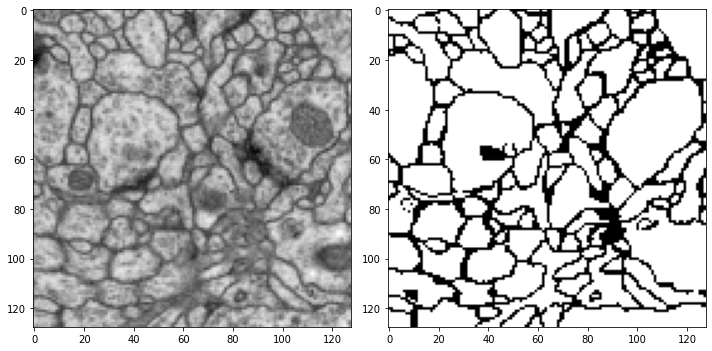

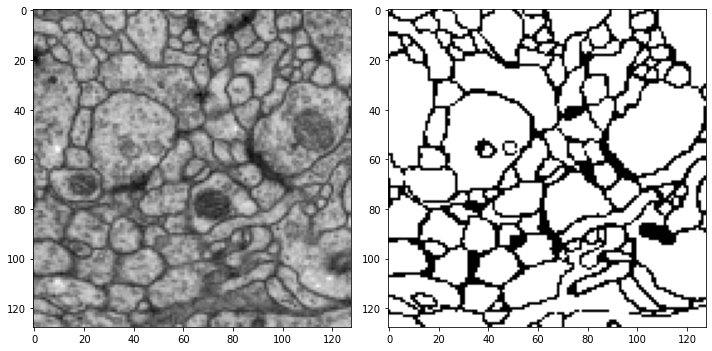

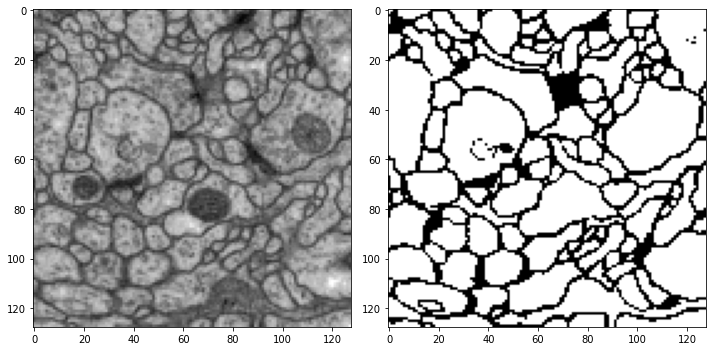

In [ ]:

img_trn = tiff.imread(data_dir+f'/train-volume.tif')
msk_trn = tiff.imread(data_dir+f'/train-labels.tif')

print(img_trn.shape)
print(msk_trn.shape)
index=1 
for img,msk in zip(img_trn, msk_trn):
    _img = resize(img, (128,128))
    _msk = resize(msk, (128,128)).round()
    fig,_ = plt.subplots(nrows=1, ncols=2)
    fig.axes[0].imshow(_img, cmap='gray')
    fig.axes[1].imshow(_msk, cmap='gray')
    plt.show()
    if(index==3):
      break
    index+=1


#Training

In [ ]:


logger = logging.getLogger(funcname())

model = UNet()
model.config['checkpoint_path_config'] = model.checkpoint_name + '.config'
model.config['checkpoint_path_history'] = model.checkpoint_name + '.history'
model.config['transform_train'] = True
model.config['nb_epoch'] = epoches

np.random.seed(model.config['seed'])
model.load_data()
model.save()
model.compile()
model.net.summary()
# if args['net']:
logger.info('Loading saved weights')
model.net.load_weights(model_path+f'/unet_jocic_128_val_loss.net')

model.train()
logger.info(model.evaluate())
model.save()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
convolution2d_305 (Convolution2D (None, 256, 256, 32)  320         input_17[0][0]                   
____________________________________________________________________________________________________
activation_305 (Activation)      (None, 256, 256, 32)  0           convolution2d_305[0][0]          
____________________________________________________________________________________________________
convolution2d_306 (Convolution2D (None, 256, 256, 32)  9248        activation_305[0][0]             
___________________________________________________________________________________________

KeyboardInterrupt: ignored

## Inference

(30, 512, 512)
(30, 512, 512)


<Figure size 1440x1440 with 0 Axes>

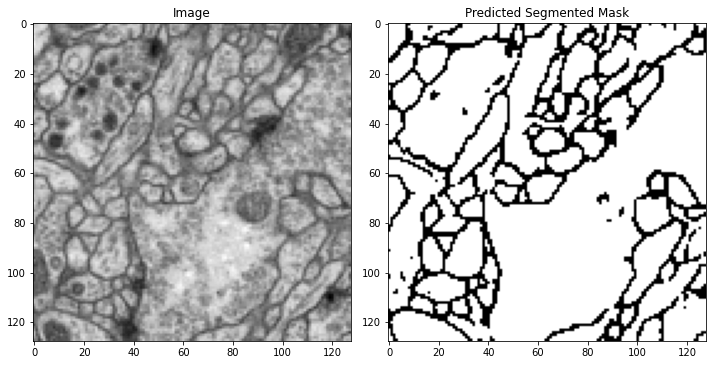

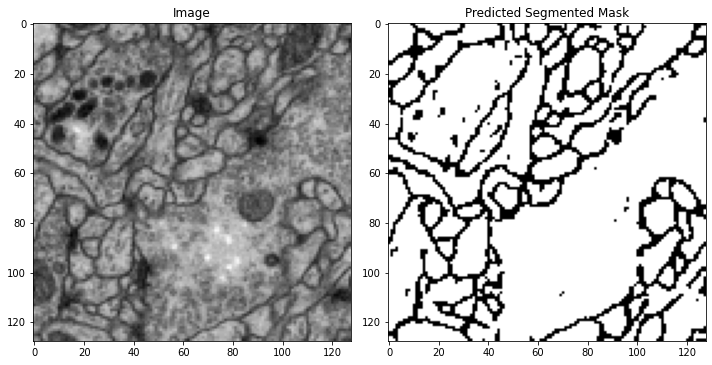

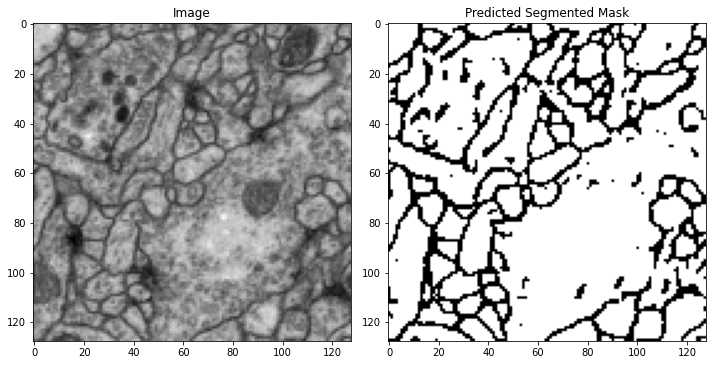

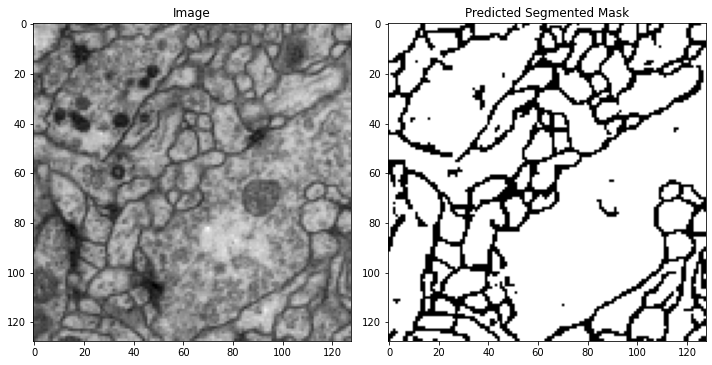

In [ ]:
# # def submit(args):
logger = logging.getLogger(funcname())

model = UNet()


# logger.info('Loading model from %s.' % args['model'])
# model.load(args['model'])

# Get the checkpoint name before tweaking input shape, etc.
chkpt_name = model.checkpoint_name

model.config['input_shape'] = model.config[
    'img_shape'] + model.config['input_shape'][-1:]
model.config['output_shape'] = model.config[
    'img_shape'] + model.config['output_shape'][-1:]
model.config['output_shape_onehot'] = model.config[
    'img_shape'] + model.config['output_shape_onehot'][-1:]

model.compile()
#model.net.summary()


logger.info('Loading saved weights')
model.net.load_weights(model_path+f'/unet_jocic_128_val_loss.net')

logger.info('Loading testing images...')
img_stack = tiff.imread('data/test-volume.tif')
X_batch, coords =model.batch_gen_submit(img_stack)

logger.info('Making predictions on batch...')
prd_batch = model.net.predict(X_batch, batch_size=model.config['batch_size'])

logger.info('Reconstructing images...')
prd_stack = np.empty(img_stack.shape)
for prd_wdw, (img_idx, y0, y1, x0, x1) in zip(prd_batch, coords):
    prd_stack[img_idx, y0:y1, x0:x1] = prd_wdw.reshape(y1 - y0, x1 - x0)
prd_stack = prd_stack.astype('float32')

logger.info('Saving full size predictions...')
tiff.imsave(chkpt_name + '.submission.tif', prd_stack)
logger.info('Done - saved file to %s.' % (chkpt_name + '.submission.tif'))


img_trn = tiff.imread(data_dir+f'/test-volume.tif')
msk_trn = tiff.imread(model_path+f'/unet_jocic_256.submission.tif')

print(img_trn.shape)
print(msk_trn.shape)
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(20,20))
index=1 
for img,msk in zip(img_trn, msk_trn):
    _img = resize(img, (128,128))
    _msk = resize(msk, (128,128)).round()
    fig,_ = plt.subplots(nrows=1, ncols=2)
    fig.axes[0].set_title('Image')
    fig.axes[0].imshow(_img, cmap='gray')
    fig.axes[1].set_title('Predicted Segmented Mask')
    fig.axes[1].imshow(_msk, cmap='gray')
    plt.show()
    if(index==4):
      break
    index+=1
